# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

In [604]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Analysing and preparing dataset for training

## 1.1 Portfolio Dataset
contains offer ids and meta data about each offer (duration, type, etc.)
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [605]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [606]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


There are only 10 entries in portfolio

In [607]:
# displaying all 10 rows
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [608]:
portfolio.groupby('offer_type').count()

,reward,channels,difficulty,duration,id
offer_type,,,,,
bogo,4,4,4,4,4
discount,4,4,4,4,4
informational,2,2,2,2,2


### 1.1.1 One-hot encoding offer_type and channels
There are 3 offer types <br>
- 4 bogo (buy one get one)
- 4 discount (get some amount off or percent off)
- 2 informational

For informational offer the reward is 0, so this feature might not appeal to customers to convert, so will remove any informational offers.

One-hot encoding on channels and offer_type

In [609]:
mlb = MultiLabelBinarizer()
channels_onehot = pd.DataFrame(mlb.fit_transform(portfolio['channels']),columns=mlb.classes_, index=portfolio.index)

offertype_onehot = pd.get_dummies(portfolio['offer_type'])
portfolio_conv = pd.concat((portfolio, channels_onehot, offertype_onehot), axis=1)

In [610]:
portfolio_conv

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [611]:
# Drop channels & offer_type
portfolio_conv.drop(['channels','offer_type'], axis = 1, inplace=True)

In [612]:
portfolio_conv

,reward,difficulty,duration,id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


## 1.2 Profile Dataset
demographic data for each customer

* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [613]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [614]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


### 1.2.1 Dropping null values 

In [615]:
profile[profile['gender'].isnull()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


From above we can see that most of the features like gender, age, income are None or NaN, so removing these rows since these won't be helpful while training the model

In [616]:
profile_conv = profile.dropna(axis=0)

In [617]:
profile_conv

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


### 1.2.2 Processing became_member_on - tenure

From **became_member_on** we can find the tenure, how long customer is with starbucks. 

In [618]:
profile_conv.groupby('became_member_on').count()

,gender,age,id,income
became_member_on,,,,
20130729,1,1,1,1
20130730,3,3,3,3
20130731,1,1,1,1
20130801,1,1,1,1
20130802,2,2,2,2
...,...,...,...,...
20180722,22,22,22,22
20180723,8,8,8,8
20180724,17,17,17,17


In [619]:
profile_conv['became_member_on'].apply(lambda x: str(x)[:4]).value_counts() 

2017    5599
2018    3669
2016    3024
2015    1597
2014     662
2013     274
Name: became_member_on, dtype: int64

In given data, users became member from 2013 to 2018. To find tenure, number of days user is with starbucks, I will use 2019-01-01 

In [620]:
def convertDateToDays(dateint):
    to_date = datetime.strptime(str(dateint),'%Y%m%d')
    from_date = datetime.strptime('20190101','%Y%m%d')
    duration = from_date - to_date
    return duration.days

In [621]:
num_of_days = profile_conv['became_member_on'].apply(lambda x: convertDateToDays(x))

In [622]:
num_of_days

1         535
3         602
5         250
8         326
12        416
         ... 
16995     211
16996     172
16997     705
16998    1030
16999     528
Name: became_member_on, Length: 14825, dtype: int64

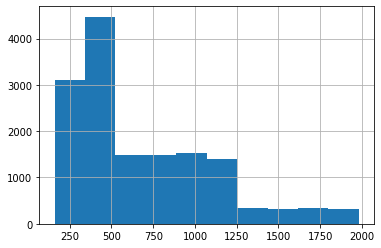

In [623]:
num_of_days.hist()

In [624]:
num_of_days[num_of_days < 500].count()

6956

In [625]:
num_of_days[(num_of_days >= 500) & (num_of_days < 1250)].count()

6514

In [626]:
num_of_days[num_of_days >= 1250].count()

1355

From above data distribution, I will form 3 groups. Customers who are with starbucks 
- less than 500 days : 6956 members
- between 500 and 1250 : 6524 members
- greater than 1250 : 1355 members

In [627]:
profile_conv['nod_lt_500'] = (num_of_days < 500).astype(int)
profile_conv['nod_gt_500_lt_5000'] = ((num_of_days >= 500) & (num_of_days < 1250)).astype(int)
profile_conv['nod_gt_1250'] = (num_of_days >= 1250).astype(int)

/Users/rchint1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/rchint1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rchint1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [628]:
profile_conv

,gender,age,id,became_member_on,income,nod_lt_500,nod_gt_500_lt_5000,nod_gt_1250
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0,1,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,0,1,0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,1,0,0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,1,0,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1,0,0
...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,1,0,0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,1,0,0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,0,1,0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,0,1,0


In [629]:
# drop became_member_on
profile_conv.drop('became_member_on', axis=1, inplace=True)

/Users/rchint1/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### 1.2.3 Processing gender

In [630]:
profile_conv.groupby('gender').count()

,age,id,income,nod_lt_500,nod_gt_500_lt_5000,nod_gt_1250
gender,,,,,,
F,6129,6129,6129,6129,6129,6129
M,8484,8484,8484,8484,8484,8484
O,212,212,212,212,212,212


6129 females, 8464 males, others 212

In [631]:
profile_conv['gender'].replace({'F':0,'M':1,'O':2}, inplace=True)

/Users/rchint1/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [632]:
profile_conv

,gender,age,id,income,nod_lt_500,nod_gt_500_lt_5000,nod_gt_1250
1,0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,0,1,0
3,0,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,1,0
5,1,68,e2127556f4f64592b11af22de27a7932,70000.0,1,0,0
8,1,65,389bc3fa690240e798340f5a15918d5c,53000.0,1,0,0
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1,0,0
...,...,...,...,...,...,...,...
16995,0,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,1,0,0
16996,1,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,1,0,0
16997,1,49,01d26f638c274aa0b965d24cefe3183f,73000.0,0,1,0
16998,0,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,0,1,0


### 1.2.4 Processing age

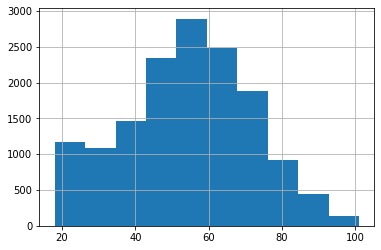

In [633]:
profile_conv['age'].hist()

from data distribution above, I will divide age group into 4
- Age less than 40 
- Age between 40 and 60
- Age between 60 and 80
- Age greater than or equal to 80

In [634]:
# Age less than 40
profile_conv[profile_conv['age'] < 40]['age'].count()

3100

In [635]:
# Age between 40 and 60
profile_conv[(profile_conv['age'] >= 40) & (profile_conv['age'] < 60)]['age'].count()

5850

In [636]:
# Age between 60 and 80
profile_conv[(profile_conv['age'] >= 60) & (profile_conv['age'] < 80)]['age'].count()

4773

In [637]:
# Age greater than or equal to 80
profile_conv[profile_conv['age'] >= 80]['age'].count()

1102

In [638]:
profile_conv['age_lt_40'] = (profile_conv['age'] < 40).astype(int)
profile_conv['age_gt_40_lt_60'] = ((profile_conv['age'] >= 40) & (profile_conv['age'] < 60)).astype(int)
profile_conv['age_gt_60_lt_80'] = ((profile_conv['age'] >= 60) & (profile_conv['age'] < 80)).astype(int)
profile_conv['age_gt_80'] = (profile_conv['age'] >= 80).astype(int)

/Users/rchint1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/rchint1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rchint1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [639]:
profile_conv

,gender,age,id,income,nod_lt_500,nod_gt_500_lt_5000,nod_gt_1250,age_lt_40,age_gt_40_lt_60,age_gt_60_lt_80,age_gt_80
1,0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,0,1,0,0,1,0,0
3,0,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,1,0,0,0,1,0
5,1,68,e2127556f4f64592b11af22de27a7932,70000.0,1,0,0,0,0,1,0
8,1,65,389bc3fa690240e798340f5a15918d5c,53000.0,1,0,0,0,0,1,0
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
16995,0,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,1,0,0,0,1,0,0
16996,1,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,1,0,0,0,0,1,0
16997,1,49,01d26f638c274aa0b965d24cefe3183f,73000.0,0,1,0,0,1,0,0
16998,0,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,0,1,0,0,0,0,1


In [640]:
# dropping age column
profile_conv.drop('age',axis=1,inplace=True)

In [641]:
profile_conv.head()

,gender,id,income,nod_lt_500,nod_gt_500_lt_5000,nod_gt_1250,age_lt_40,age_gt_40_lt_60,age_gt_60_lt_80,age_gt_80
1,0,0610b486422d4921ae7d2bf64640c50b,112000.0,0,1,0,0,1,0,0
3,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,1,0,0,0,1,0
5,1,e2127556f4f64592b11af22de27a7932,70000.0,1,0,0,0,0,1,0
8,1,389bc3fa690240e798340f5a15918d5c,53000.0,1,0,0,0,0,1,0
12,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1,0,0,0,1,0,0


### 1.2.5 processing income

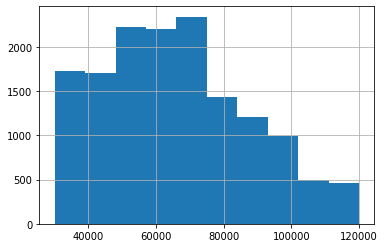

In [642]:
profile_conv['income'].hist()

based on above distribution, grouping them into 5 buckets 
- income less than 40K
- income between 40K and 60K
- income between 60K and 80K
- income between 80K and 100K
- income greater than 100K

In [643]:
# income less than 40K
profile_conv[profile_conv['income'] < 40000]['income'].count()

1940

In [644]:
# income between 40K and 60K
profile_conv[(profile_conv['income'] >= 40000) & (profile_conv['income'] <= 60000)]['income'].count()

4753

In [645]:
# income between 60K and 80K
profile_conv[(profile_conv['income'] >= 60000) & (profile_conv['income'] <= 80000)]['income'].count()

4818

In [646]:
# income between 80K and 100K
profile_conv[(profile_conv['income'] >= 80000) & (profile_conv['income'] <= 100000)]['income'].count()

2711

In [647]:
# income greater than 100K
profile_conv[(profile_conv['income'] >= 100000)]['income'].count()

1093

In [648]:
profile_conv['in_lt_40k'] = (profile_conv['income'] < 40000).astype(int)
profile_conv['in_gt_40k_lt_60k'] = ((profile_conv['income'] >= 40000) & (profile_conv['income'] < 60000)).astype(int)
profile_conv['in_gt_60k_lt_80k'] = ((profile_conv['income'] >= 60000) & (profile_conv['income'] < 80000)).astype(int)
profile_conv['in_gt_80k_lt_100k'] = ((profile_conv['income'] >= 80000) & (profile_conv['income'] < 100000)).astype(int)
profile_conv['in_gt_100k'] = (profile_conv['income'] >= 100000).astype(int)

/Users/rchint1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/rchint1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rchint1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [649]:
profile_conv.drop('income', axis=1, inplace=True)
profile_conv.head()

,gender,id,nod_lt_500,nod_gt_500_lt_5000,nod_gt_1250,age_lt_40,age_gt_40_lt_60,age_gt_60_lt_80,age_gt_80,in_lt_40k,in_gt_40k_lt_60k,in_gt_60k_lt_80k,in_gt_80k_lt_100k,in_gt_100k
1,0,0610b486422d4921ae7d2bf64640c50b,0,1,0,0,1,0,0,0,0,0,0,1
3,0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,0,1,0,0,0,0,0,1
5,1,e2127556f4f64592b11af22de27a7932,1,0,0,0,0,1,0,0,0,1,0,0
8,1,389bc3fa690240e798340f5a15918d5c,1,0,0,0,0,1,0,0,1,0,0,0
12,1,2eeac8d8feae4a8cad5a6af0499a211d,1,0,0,0,1,0,0,0,1,0,0,0


## 1.3 Transcript Dataset
records for transactions, offers received, offers viewed, and offers completed

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [650]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [651]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### 1.3.1 find any null values

In [652]:
transcript.dropna(axis=0)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


There are no null values

### 1.3.2 Removing informational transactions
Since informational offers are not helping to convert removing those

In [653]:
off_view_or_receive = transcript[(transcript['event'] == 'offer received') | (transcript['event'] == 'offer viewed')]

informational_offers = portfolio_conv[portfolio_conv['informational'] == 1]['id'].values

inf_off_1 = off_view_or_receive[off_view_or_receive['value'] == {'offer id': informational_offers[0]}]
inf_off_2 = off_view_or_receive[off_view_or_receive['value'] == {'offer id': informational_offers[1]}]

transcript.drop(inf_off_1.index, inplace=True)
transcript.drop(inf_off_2.index, inplace=True)

In [654]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


### 1.3.3 Processing transactional data

In [655]:
transaction_data = transcript[transcript['event'] == 'transaction']
transaction_data['amount'] = transaction_data['value'].apply(lambda x: x['amount'])
transaction_data.drop(['event', 'value'], axis=1, inplace=True)

/Users/rchint1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [656]:
transaction_data

,person,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97
...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53
306531,a00058cf10334a308c68e7631c529907,714,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53


In [657]:
# getting amount spent per customer
transaction_final = transaction_data.groupby('person').sum().drop('time', axis=1)
# getting number of transactions made by customer
transaction_final['no_of_trans'] = transaction_data.groupby('person').count().drop('time', axis=1)
# getting time spent in test by customer
transaction_final['time_spent_in_hrs'] = transaction_data.groupby('person').max().drop('amount', axis=1)

In [658]:
transaction_final

,amount,no_of_trans,time_spent_in_hrs
person,,,
0009655768c64bdeb2e877511632db8f,127.60,8,696
00116118485d4dfda04fdbaba9a87b5c,4.09,3,474
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,654
0020c2b971eb4e9188eac86d93036a77,196.86,8,708
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,672
...,...,...,...
fff3ba4757bd42088c044ca26d73817a,580.98,11,552
fff7576017104bcc8677a8d63322b5e1,29.94,6,696
fff8957ea8b240a6b5e634b6ee8eafcf,12.15,5,576


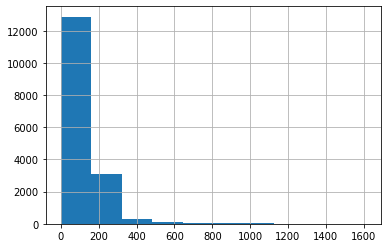

In [659]:
transaction_final['amount'].hist()

From above, amount user spent can be grouped into 5 buckets
- who spent less than 20
- who spent between 20 & 50
- who spent between 50 & 100
- who spent between 100 & 200
- who spent mroe than 200

In [660]:
# who spent less than 20
print(transaction_final[transaction_final['amount'] < 20]['amount'].count())
# who spent between 20 & 50
print(transaction_final[(transaction_final['amount'] >= 20) & (transaction_final['amount'] < 50)]['amount'].count())
# who spent between 50 & 100
print(transaction_final[(transaction_final['amount'] >= 50) & (transaction_final['amount'] < 100)]['amount'].count())
# who spent between 100 & 200
print(transaction_final[(transaction_final['amount'] >= 100) & (transaction_final['amount'] < 200)]['amount'].count())
# who spent mroe than 200
print(transaction_final[transaction_final['amount'] >= 200]['amount'].count())

3493
3297
3066
4373
2349


In [661]:
transaction_final['amt_lt_20'] = (transaction_final['amount'] < 20).astype(int)
transaction_final['amt_gt_20_lt_50'] = \
                        ((transaction_final['amount'] >= 20) & (transaction_final['amount'] < 50)).astype(int)
transaction_final['amt_gt_50_lt_100'] = \
                        ((transaction_final['amount'] >= 50) & (transaction_final['amount'] < 100)).astype(int)
transaction_final['amt_gt_100_lt_200'] = \
                        ((transaction_final['amount'] >= 100) & (transaction_final['amount'] < 200)).astype(int)
transaction_final['amt_gt_200'] = (transaction_final['amount'] >= 200).astype(int)

In [662]:
transaction_final.head()

,amount,no_of_trans,time_spent_in_hrs,amt_lt_20,amt_gt_20_lt_50,amt_gt_50_lt_100,amt_gt_100_lt_200,amt_gt_200
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,696,0,0,0,1,0
00116118485d4dfda04fdbaba9a87b5c,4.09,3,474,1,0,0,0,0
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,654,0,0,1,0,0
0020c2b971eb4e9188eac86d93036a77,196.86,8,708,0,0,0,1,0
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,672,0,0,0,1,0


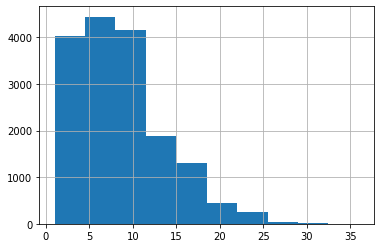

In [663]:
transaction_final['no_of_trans'].hist()

From above, number of transactions made can be grouped like below 
- less than 5
- between 5 & 10
- more than 10

In [664]:
# less than 5
print(transaction_final[transaction_final['no_of_trans'] < 5]['no_of_trans'].count())
# between 5 & 10
print(transaction_final[(transaction_final['no_of_trans'] >= 5) & \
                  (transaction_final['no_of_trans'] < 10)]['no_of_trans'].count())
# more than 10
print(transaction_final[transaction_final['no_of_trans'] >= 10]['no_of_trans'].count())

4037
6736
5805


In [665]:
transaction_final['trans_lt_5'] = (transaction_final['no_of_trans'] < 5).astype(int)
transaction_final['trans_gt_5_lt_10'] = \
              ((transaction_final['no_of_trans'] >= 5) & (transaction_final['no_of_trans'] < 10)).astype(int)
transaction_final['trans_gt_10'] = (transaction_final['no_of_trans'] >= 10).astype(int)

In [666]:
transaction_final.head()

,amount,no_of_trans,time_spent_in_hrs,amt_lt_20,amt_gt_20_lt_50,amt_gt_50_lt_100,amt_gt_100_lt_200,amt_gt_200,trans_lt_5,trans_gt_5_lt_10,trans_gt_10
person,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,696,0,0,0,1,0,0,1,0
00116118485d4dfda04fdbaba9a87b5c,4.09,3,474,1,0,0,0,0,1,0,0
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,654,0,0,1,0,0,0,1,0
0020c2b971eb4e9188eac86d93036a77,196.86,8,708,0,0,0,1,0,0,1,0
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,672,0,0,0,1,0,0,0,1


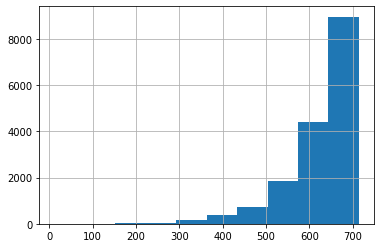

In [667]:
transaction_final['time_spent_in_hrs'].hist()

From above, each customer time spent in test can be grouped like below
- spent less than 600 hrs
- spent between 600 and 650 hrs
- spent between 650 and 690 hrs
- spent greater than 690 hrs

In [668]:
# spent less than 600 hrs
print(transaction_final[transaction_final['time_spent_in_hrs'] < 600]['time_spent_in_hrs'].count())

# spent between 600 and 650 hrs
print(transaction_final[(transaction_final['time_spent_in_hrs'] >= 600) & \
                  (transaction_final['time_spent_in_hrs'] < 650)]['time_spent_in_hrs'].count())

# spent between 650 and 690 hrs
print(transaction_final[(transaction_final['time_spent_in_hrs'] >= 650) & \
                  (transaction_final['time_spent_in_hrs'] < 690)]['time_spent_in_hrs'].count())

# spent greater than 690 hrs
print(transaction_final[transaction_final['time_spent_in_hrs'] >= 690]['time_spent_in_hrs'].count())

4242
3950
4091
4295


In [669]:
transaction_final['ts_lt_600'] = (transaction_final['time_spent_in_hrs'] < 600).astype(int)
transaction_final['ts_gt_600_lt_650'] = \
         ((transaction_final['time_spent_in_hrs'] >= 600) & (transaction_final['time_spent_in_hrs'] < 650)).astype(int)
transaction_final['ts_gt_650_lt_690'] = \
         ((transaction_final['time_spent_in_hrs'] >= 650) & (transaction_final['time_spent_in_hrs'] < 690)).astype(int)
transaction_final['ts_gt_690'] = (transaction_final['time_spent_in_hrs'] >= 690).astype(int)


In [670]:
transaction_final.head()

,amount,no_of_trans,time_spent_in_hrs,amt_lt_20,amt_gt_20_lt_50,amt_gt_50_lt_100,amt_gt_100_lt_200,amt_gt_200,trans_lt_5,trans_gt_5_lt_10,trans_gt_10,ts_lt_600,ts_gt_600_lt_650,ts_gt_650_lt_690,ts_gt_690
person,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,696,0,0,0,1,0,0,1,0,0,0,0,1
00116118485d4dfda04fdbaba9a87b5c,4.09,3,474,1,0,0,0,0,1,0,0,1,0,0,0
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,654,0,0,1,0,0,0,1,0,0,0,1,0
0020c2b971eb4e9188eac86d93036a77,196.86,8,708,0,0,0,1,0,0,1,0,0,0,0,1
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,672,0,0,0,1,0,0,0,1,0,0,1,0


In [671]:
# drop amount, no_of_trans & time_spent_in_hrs
transaction_final.drop(['amount', 'no_of_trans', 'time_spent_in_hrs'], axis=1, inplace=True)

transaction_final

,amt_lt_20,amt_gt_20_lt_50,amt_gt_50_lt_100,amt_gt_100_lt_200,amt_gt_200,trans_lt_5,trans_gt_5_lt_10,trans_gt_10,ts_lt_600,ts_gt_600_lt_650,ts_gt_650_lt_690,ts_gt_690
person,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0,0,0,1,0,0,1,0,0,0,0,1
00116118485d4dfda04fdbaba9a87b5c,1,0,0,0,0,1,0,0,1,0,0,0
0011e0d4e6b944f998e987f904e8c1e5,0,0,1,0,0,0,1,0,0,0,1,0
0020c2b971eb4e9188eac86d93036a77,0,0,0,1,0,0,1,0,0,0,0,1
0020ccbbb6d84e358d3414a3ff76cffd,0,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,0,0,0,0,1,0,0,1,1,0,0,0
fff7576017104bcc8677a8d63322b5e1,0,1,0,0,0,0,1,0,0,0,0,1
fff8957ea8b240a6b5e634b6ee8eafcf,1,0,0,0,0,0,1,0,1,0,0,0


In [672]:
# Removing transaction data
transcript.drop(transaction_data.index, axis=0, inplace=True)

In [699]:
transaction_final.reset_index(level=0, inplace=True)
transaction_final

,person,amt_lt_20,amt_gt_20_lt_50,amt_gt_50_lt_100,amt_gt_100_lt_200,amt_gt_200,trans_lt_5,trans_gt_5_lt_10,trans_gt_10,ts_lt_600,ts_gt_600_lt_650,ts_gt_650_lt_690,ts_gt_690
0,0009655768c64bdeb2e877511632db8f,0,0,0,1,0,0,1,0,0,0,0,1
1,00116118485d4dfda04fdbaba9a87b5c,1,0,0,0,0,1,0,0,1,0,0,0
2,0011e0d4e6b944f998e987f904e8c1e5,0,0,1,0,0,0,1,0,0,0,1,0
3,0020c2b971eb4e9188eac86d93036a77,0,0,0,1,0,0,1,0,0,0,0,1
4,0020ccbbb6d84e358d3414a3ff76cffd,0,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,0,0,0,0,1,0,0,1,1,0,0,0
16574,fff7576017104bcc8677a8d63322b5e1,0,1,0,0,0,0,1,0,0,0,0,1
16575,fff8957ea8b240a6b5e634b6ee8eafcf,1,0,0,0,0,0,1,0,1,0,0,0
16576,fffad4f4828548d1b5583907f2e9906b,0,0,1,0,0,0,0,1,0,0,1,0


### 1.3.4 processing offer received and viewed
Since offer completed will be the actual output event we are looking for, we can convert this to number of offers customer received and viewed

In [703]:
offer_received = pd.DataFrame(transcript[transcript['event'] == 'offer received'].groupby('person').count()['event'])
offer_received.reset_index(level=0, inplace=True)
offer_received

,person,event
0,0009655768c64bdeb2e877511632db8f,3
1,00116118485d4dfda04fdbaba9a87b5c,2
2,0011e0d4e6b944f998e987f904e8c1e5,3
3,0020c2b971eb4e9188eac86d93036a77,4
4,0020ccbbb6d84e358d3414a3ff76cffd,3
...,...,...
16923,fff3ba4757bd42088c044ca26d73817a,4
16924,fff7576017104bcc8677a8d63322b5e1,5
16925,fff8957ea8b240a6b5e634b6ee8eafcf,2
16926,fffad4f4828548d1b5583907f2e9906b,3


In [704]:
offer_viewed = pd.DataFrame(transcript[transcript['event'] == 'offer viewed'].groupby('person').count()['event'])
offer_viewed.reset_index(level=0, inplace=True)
offer_viewed

,person,event
0,0009655768c64bdeb2e877511632db8f,2
1,00116118485d4dfda04fdbaba9a87b5c,2
2,0011e0d4e6b944f998e987f904e8c1e5,3
3,0020c2b971eb4e9188eac86d93036a77,2
4,0020ccbbb6d84e358d3414a3ff76cffd,3
...,...,...
16518,fff3ba4757bd42088c044ca26d73817a,2
16519,fff7576017104bcc8677a8d63322b5e1,4
16520,fff8957ea8b240a6b5e634b6ee8eafcf,2
16521,fffad4f4828548d1b5583907f2e9906b,3


Offer received is superset, all received offer, but only few people viewed or done transactions
- offer_received has 16928 records
- transaction_final has 16578 records
- offer_viewed has 16523

In [705]:
# renaming columns for merge
offer_received.rename(columns={'person': 'person_id', 'event': 'offers_received'}, inplace=True)
offer_viewed.rename(columns={'person': 'person_id', 'event': 'offers_viewed'}, inplace=True)
transaction_final.rename(columns={'person': 'person_id'}, inplace=True)

In [708]:
# merging offer_viewed to offer_received
offer_details = pd.merge(pd.merge(offer_received, offer_viewed, on='person_id', how="left"), \
         transaction_final, on='person_id', how="left")
offer_details

,person_id,offers_received,offers_viewed,amt_lt_20,amt_gt_20_lt_50,amt_gt_50_lt_100,amt_gt_100_lt_200,amt_gt_200,trans_lt_5,trans_gt_5_lt_10,trans_gt_10,ts_lt_600,ts_gt_600_lt_650,ts_gt_650_lt_690,ts_gt_690
0,0009655768c64bdeb2e877511632db8f,3,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,00116118485d4dfda04fdbaba9a87b5c,2,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,3,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0020c2b971eb4e9188eac86d93036a77,4,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0020ccbbb6d84e358d3414a3ff76cffd,3,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16923,fff3ba4757bd42088c044ca26d73817a,4,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
16924,fff7576017104bcc8677a8d63322b5e1,5,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
16925,fff8957ea8b240a6b5e634b6ee8eafcf,2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
16926,fffad4f4828548d1b5583907f2e9906b,3,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [711]:
offer_details.isnull().values.any()

True

Above is expected, since some records might not have offer recieved or transactions, so filling them with 0.

In [712]:
offer_details = offer_details.fillna(0)

In [713]:
offer_details.isnull().values.any()

False

In [716]:
# since we are done with offer received and offer viewed, drop those records
transcript.drop(transcript[transcript['event'] == 'offer received'].index, axis=0, inplace=True)
transcript.drop(transcript[transcript['event'] == 'offer viewed'].index, axis=0, inplace=True)

### 1.3.4 processing event

16928 members got offer, 16523 viewed the offer,  12774 persons completed offer. 

In [808]:
transcript_conv = pd.concat((transcript, pd.get_dummies(transcript['event'])), axis=1)
transcript_conv

,person,event,value,time,offer completed
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,1
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,1
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,1
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,1
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,1
...,...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,1
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,1
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,1
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,1


In [809]:
transcript_conv['offer'] = transcript_conv['value'].apply(lambda x: x['offer_id'])
transcript_conv['reward_earned'] = transcript_conv['value'].apply(lambda x: x['reward'])
transcript_conv

,person,event,value,time,offer completed,offer,reward_earned
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,1,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,1,fafdcd668e3743c1bb461111dcafc2a4,2
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,1,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,10
...,...,...,...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,1,2298d6c36e964ae4a3e7e9706d1fb8c2,3
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,1,2298d6c36e964ae4a3e7e9706d1fb8c2,3
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,1,fafdcd668e3743c1bb461111dcafc2a4,2
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,1,fafdcd668e3743c1bb461111dcafc2a4,2


In [810]:
transcript_conv['reward_earned'] = transcript_conv['reward_earned'].fillna(0)
transcript_conv.head()

,person,event,value,time,offer completed,offer,reward_earned
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,1,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,1,fafdcd668e3743c1bb461111dcafc2a4,2
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,1,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,10


In [811]:
# drop time, event, value columns
transcript_conv.drop(['time', 'event', 'value'], axis=1, inplace=True)

In [812]:
transcript_conv.rename(columns={'person': 'person_id', 'offer': 'offer_id'}, inplace=True)
transcript_conv.head()

,person_id,offer completed,offer_id,reward_earned
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,1,fafdcd668e3743c1bb461111dcafc2a4,2
12679,629fc02d56414d91bca360decdfa9288,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,676506bad68e4161b9bbaffeb039626b,1,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,1,4d5c57ea9a6940dd891ad53e9dbe8da0,10


In [813]:
portfolio_conv.rename(columns={'id': 'offer_id'}, inplace=True)

In [814]:
transcript_conv = pd.merge(transcript_conv, portfolio_conv, on='offer_id')
transcript_conv

,person_id,offer completed,offer_id,reward_earned,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,2906b810c7d4411798c6938adc9daaa5,2,2,10,7,1,1,0,1,0,1,0
1,73ffefd41e9a4ca3ab26b2b3697c6eb7,1,2906b810c7d4411798c6938adc9daaa5,2,2,10,7,1,1,0,1,0,1,0
2,24115a61df25473e84a8a03f3c98de1a,1,2906b810c7d4411798c6938adc9daaa5,2,2,10,7,1,1,0,1,0,1,0
3,2481f1fcfbcb4b288e5a03af02d95373,1,2906b810c7d4411798c6938adc9daaa5,2,2,10,7,1,1,0,1,0,1,0
4,a45b69f1c8554ae7af83e74426ca437a,1,2906b810c7d4411798c6938adc9daaa5,2,2,10,7,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33574,5cb65af515664bb0b39cdaa089244dc7,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,5,20,10,1,0,0,1,0,1,0
33575,0dc85918181e4c3eb0e412d37fa8a552,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,5,20,10,1,0,0,1,0,1,0
33576,f74033a8c6834303bd1b3ef0c98d11d8,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,5,20,10,1,0,0,1,0,1,0
33577,f3e801caeafe4899b3b989b586e74ac7,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,5,20,10,1,0,0,1,0,1,0


In [822]:
transcript_conv = pd.merge(transcript_conv.groupby('person_id').count()\
    [['email', 'mobile', 'social', 'web', 'bogo', 'discount', 'offer completed']].reset_index(level=0),\
        transcript_conv.groupby('person_id').sum()\
  [['reward_earned', 'reward', 'difficulty', 'duration']].reset_index(level=0), on='person_id')

In [823]:
transcript_conv.columns

Index(['person_id', 'email', 'mobile', 'social', 'web', 'bogo', 'discount',
       'offer completed', 'reward_earned', 'reward', 'difficulty', 'duration'],
      dtype='object')

In [824]:
final = pd.merge(offer_details, transcript_conv, on='person_id', how='left')

In [825]:
final.columns

Index(['person_id', 'offers_received', 'offers_viewed', 'amt_lt_20',
       'amt_gt_20_lt_50', 'amt_gt_50_lt_100', 'amt_gt_100_lt_200',
       'amt_gt_200', 'trans_lt_5', 'trans_gt_5_lt_10', 'trans_gt_10',
       'ts_lt_600', 'ts_gt_600_lt_650', 'ts_gt_650_lt_690', 'ts_gt_690',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount',
       'offer completed', 'reward_earned', 'reward', 'difficulty', 'duration'],
      dtype='object')

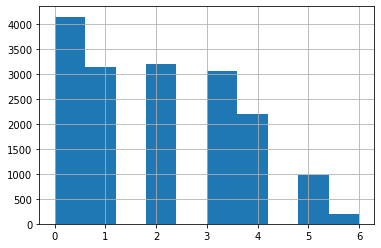

In [826]:
final['offer completed'] = final['offer completed'].fillna(0)
final['offer completed'].hist()

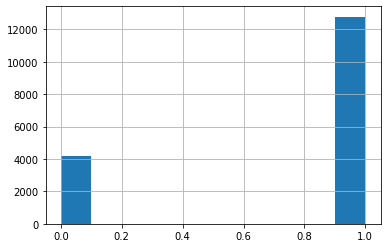

In [827]:
final['offer_success'] = final['offer completed'].apply(lambda x: 1 if x>0 else 0)
final['offer_success'].hist()

In [828]:
final

,person_id,offers_received,offers_viewed,amt_lt_20,amt_gt_20_lt_50,amt_gt_50_lt_100,amt_gt_100_lt_200,amt_gt_200,trans_lt_5,trans_gt_5_lt_10,...,social,web,bogo,discount,offer completed,reward_earned,reward,difficulty,duration,offer_success
0,0009655768c64bdeb2e877511632db8f,3,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,3.0,3.0,3.0,3.0,3.0,9.0,9.0,25.0,22.0,1
1,00116118485d4dfda04fdbaba9a87b5c,2,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0
2,0011e0d4e6b944f998e987f904e8c1e5,3,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,3.0,3.0,3.0,3.0,3.0,13.0,13.0,32.0,24.0,1
3,0020c2b971eb4e9188eac86d93036a77,4,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,3.0,3.0,3.0,3.0,3.0,14.0,14.0,30.0,25.0,1
4,0020ccbbb6d84e358d3414a3ff76cffd,3,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,13.0,13.0,17.0,19.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16923,fff3ba4757bd42088c044ca26d73817a,4,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,9.0,9.0,25.0,24.0,1
16924,fff7576017104bcc8677a8d63322b5e1,5,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,3.0,3.0,3.0,3.0,3.0,9.0,9.0,25.0,27.0,1
16925,fff8957ea8b240a6b5e634b6ee8eafcf,2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0
16926,fffad4f4828548d1b5583907f2e9906b,3,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,15.0,15.0,15.0,17.0,1


In [829]:
# Merging profile data to transcript_conv
final = pd.merge(final, profile_conv, on='person_id', how='left')
final = final.fillna(0)

In [830]:
final

,person_id,offers_received,offers_viewed,amt_lt_20,amt_gt_20_lt_50,amt_gt_50_lt_100,amt_gt_100_lt_200,amt_gt_200,trans_lt_5,trans_gt_5_lt_10,...,nod_gt_1250,age_lt_40,age_gt_40_lt_60,age_gt_60_lt_80,age_gt_80,in_lt_40k,in_gt_40k_lt_60k,in_gt_60k_lt_80k,in_gt_80k_lt_100k,in_gt_100k
0,0009655768c64bdeb2e877511632db8f,3,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,00116118485d4dfda04fdbaba9a87b5c,2,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,3,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0020c2b971eb4e9188eac86d93036a77,4,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0020ccbbb6d84e358d3414a3ff76cffd,3,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16923,fff3ba4757bd42088c044ca26d73817a,4,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
16924,fff7576017104bcc8677a8d63322b5e1,5,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
16925,fff8957ea8b240a6b5e634b6ee8eafcf,2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
16926,fffad4f4828548d1b5583907f2e9906b,3,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [831]:
final.columns

Index(['person_id', 'offers_received', 'offers_viewed', 'amt_lt_20',
       'amt_gt_20_lt_50', 'amt_gt_50_lt_100', 'amt_gt_100_lt_200',
       'amt_gt_200', 'trans_lt_5', 'trans_gt_5_lt_10', 'trans_gt_10',
       'ts_lt_600', 'ts_gt_600_lt_650', 'ts_gt_650_lt_690', 'ts_gt_690',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount',
       'offer completed', 'reward_earned', 'reward', 'difficulty', 'duration',
       'offer_success', 'gender', 'nod_lt_500', 'nod_gt_500_lt_5000',
       'nod_gt_1250', 'age_lt_40', 'age_gt_40_lt_60', 'age_gt_60_lt_80',
       'age_gt_80', 'in_lt_40k', 'in_gt_40k_lt_60k', 'in_gt_60k_lt_80k',
       'in_gt_80k_lt_100k', 'in_gt_100k'],
      dtype='object')

In [832]:
# drop person_id & offer completed
final.drop(['person_id', 'offer completed'], axis=1, inplace=True)
final.shape

(16928, 38)

In [833]:
final

,offers_received,offers_viewed,amt_lt_20,amt_gt_20_lt_50,amt_gt_50_lt_100,amt_gt_100_lt_200,amt_gt_200,trans_lt_5,trans_gt_5_lt_10,trans_gt_10,...,nod_gt_1250,age_lt_40,age_gt_40_lt_60,age_gt_60_lt_80,age_gt_80,in_lt_40k,in_gt_40k_lt_60k,in_gt_60k_lt_80k,in_gt_80k_lt_100k,in_gt_100k
0,3,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16923,4,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
16924,5,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
16925,2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
16926,3,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### 1.4 Merging above all into one final dataset

In [431]:
# rename columns 
transcript_conv.rename(columns={'person': 'person_id', 'offer': 'offer_id'}, inplace=True)
profile_conv.rename(columns={'id': 'person_id'}, inplace=True)
portfolio_conv.rename(columns={'id': 'offer_id'}, inplace=True)

/Users/rchint1/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [460]:
transaction_final['person_id'] = transaction_final.index
transaction_final.reset_index(level=0, inplace=True)
transaction_final.drop('person', axis=1, inplace=True)
transaction_final

,amt_lt_20,amt_gt_20_lt_50,amt_gt_50_lt_100,amt_gt_100_lt_200,amt_gt_200,trans_lt_5,trans_gt_5_lt_10,trans_gt_10,ts_lt_600,ts_gt_600_lt_650,ts_gt_650_lt_690,ts_gt_690,person_id
0,0,0,0,1,0,0,1,0,0,0,0,1,0009655768c64bdeb2e877511632db8f
1,1,0,0,0,0,1,0,0,1,0,0,0,00116118485d4dfda04fdbaba9a87b5c
2,0,0,1,0,0,0,1,0,0,0,1,0,0011e0d4e6b944f998e987f904e8c1e5
3,0,0,0,1,0,0,1,0,0,0,0,1,0020c2b971eb4e9188eac86d93036a77
4,0,0,0,1,0,0,0,1,0,0,1,0,0020ccbbb6d84e358d3414a3ff76cffd
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,0,0,0,0,1,0,0,1,1,0,0,0,fff3ba4757bd42088c044ca26d73817a
16574,0,1,0,0,0,0,1,0,0,0,0,1,fff7576017104bcc8677a8d63322b5e1
16575,1,0,0,0,0,0,1,0,1,0,0,0,fff8957ea8b240a6b5e634b6ee8eafcf
16576,0,0,1,0,0,0,0,1,0,0,1,0,fffad4f4828548d1b5583907f2e9906b


In [521]:
# Merging profile data to transcript_conv
transcript_conv = pd.merge(transcript_conv, profile_conv, on='person_id')

In [522]:
transcript_conv

,person_id,offer completed,offer received,offer viewed,offer_id,reward,gender,nod_lt_500,nod_gt_500_lt_5000,nod_gt_1250,age_lt_40,age_gt_40_lt_60,age_gt_60_lt_80,age_gt_80,in_lt_40k,in_gt_40k_lt_60k,in_gt_60k_lt_80k,in_gt_80k_lt_100k,in_gt_100k
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,0,1,0,0,0,1,0,0,0,0,0,1
2,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,0,0,1,0,0,0,1,0,0,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0,0,1,0,0,0,1,0,0,0,0,0,1
4,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,ae264e3637204a6fb9bb56bc8210ddfd,0.0,0,0,1,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126140,9fcbff4f8d7241faa4ab8a9d19c8a812,0,0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,1,1,0,0,0,1,0,0,0,0,0,1,0
126141,5d6fe66ee0764083ba82abc7af9f7a97,0,1,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1,0,1,0,0,1,0,0,0,1,0,0,0
126142,5d6fe66ee0764083ba82abc7af9f7a97,0,0,1,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1,0,1,0,0,1,0,0,0,1,0,0,0
126143,6336013a90cf4971ab0e41ad08a858db,0,1,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1,1,0,0,1,0,0,0,1,0,0,0,0


In [524]:
# Merging transaction data to transcript_conv
transcript_conv = pd.merge(transcript_conv, transaction_final, on='person_id')

In [525]:
transcript_conv.columns

Index(['person_id', 'offer completed', 'offer received', 'offer viewed',
       'offer_id', 'reward', 'gender', 'nod_lt_500', 'nod_gt_500_lt_5000',
       'nod_gt_1250', 'age_lt_40', 'age_gt_40_lt_60', 'age_gt_60_lt_80',
       'age_gt_80', 'in_lt_40k', 'in_gt_40k_lt_60k', 'in_gt_60k_lt_80k',
       'in_gt_80k_lt_100k', 'in_gt_100k', 'amt_lt_20', 'amt_gt_20_lt_50',
       'amt_gt_50_lt_100', 'amt_gt_100_lt_200', 'amt_gt_200', 'trans_lt_5',
       'trans_gt_5_lt_10', 'trans_gt_10', 'ts_lt_600', 'ts_gt_600_lt_650',
       'ts_gt_650_lt_690', 'ts_gt_690'],
      dtype='object')

In [527]:
# Merging portfolio_conv data to transcript_conv
transcript_conv = pd.merge(transcript_conv, portfolio_conv, on='offer_id')

In [530]:
transcript_conv

,person_id,offer completed,offer received,offer viewed,offer_id,reward_x,gender,nod_lt_500,nod_gt_500_lt_5000,nod_gt_1250,...,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,0,1,0,...,5,5,7,1,1,0,1,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,0,1,0,...,5,5,7,1,1,0,1,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,0,0,1,0,...,5,5,7,1,1,0,1,1,0,0
3,e2127556f4f64592b11af22de27a7932,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1,1,0,0,...,5,5,7,1,1,0,1,1,0,0
4,e2127556f4f64592b11af22de27a7932,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1,1,0,0,...,5,5,7,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124015,c207a8a8ef5c47ee970ca45f859e07eb,0,0,1,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0,1,0,0,...,3,7,7,1,1,1,1,0,1,0
124016,c207a8a8ef5c47ee970ca45f859e07eb,1,0,0,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,0,1,0,0,...,3,7,7,1,1,1,1,0,1,0
124017,9a3f45cf29ef428b932492c7a5d6ac52,0,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,1,0,1,0,...,3,7,7,1,1,1,1,0,1,0
124018,9a3f45cf29ef428b932492c7a5d6ac52,0,0,1,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,1,0,1,0,...,3,7,7,1,1,1,1,0,1,0


In [532]:
transcript_conv.drop(['person_id', 'offer_id'], axis=1, inplace=True)

Below is the final set of features

In [533]:
transcript_conv.columns

Index(['offer completed', 'offer received', 'offer viewed', 'reward_x',
       'gender', 'nod_lt_500', 'nod_gt_500_lt_5000', 'nod_gt_1250',
       'age_lt_40', 'age_gt_40_lt_60', 'age_gt_60_lt_80', 'age_gt_80',
       'in_lt_40k', 'in_gt_40k_lt_60k', 'in_gt_60k_lt_80k',
       'in_gt_80k_lt_100k', 'in_gt_100k', 'amt_lt_20', 'amt_gt_20_lt_50',
       'amt_gt_50_lt_100', 'amt_gt_100_lt_200', 'amt_gt_200', 'trans_lt_5',
       'trans_gt_5_lt_10', 'trans_gt_10', 'ts_lt_600', 'ts_gt_600_lt_650',
       'ts_gt_650_lt_690', 'ts_gt_690', 'reward_y', 'difficulty', 'duration',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount',
       'informational'],
      dtype='object')

We have 124020 records and 38 input features and 1 output feature `offer completed`

In [534]:
transcript_conv.shape

(124020, 39)

In [537]:
transcript_conv.head()

,offer completed,offer received,offer viewed,reward_x,gender,nod_lt_500,nod_gt_500_lt_5000,nod_gt_1250,age_lt_40,age_gt_40_lt_60,...,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,0,1,0,0.0,0,0,1,0,0,0,...,5,5,7,1,1,0,1,1,0,0
1,0,0,1,0.0,0,0,1,0,0,0,...,5,5,7,1,1,0,1,1,0,0
2,1,0,0,5.0,0,0,1,0,0,0,...,5,5,7,1,1,0,1,1,0,0
3,0,1,0,0.0,1,1,0,0,0,0,...,5,5,7,1,1,0,1,1,0,0
4,0,0,1,0.0,1,1,0,0,0,0,...,5,5,7,1,1,0,1,1,0,0


# 2. Split data for training and testing

In [834]:
X = final.drop('offer_success', axis=1)
y = pd.DataFrame(final['offer_success'])

In [835]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [836]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13542, 37)
(3386, 37)
(13542, 1)
(3386, 1)


# 3. Training the model

## 3.1 Using Naive Bayes 

In [837]:
# Instantiate our model
naive_bayes = MultinomialNB()

# Fit our model to the training data
naive_bayes.fit(X_train, y_train)

/Users/rchint1/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## 3.2 Using sklearn ensemble

In [838]:
# Instantiate a BaggingClassifier with:
# 200 weak learners (n_estimators) and everything else a default values
bagging_mod = BaggingClassifier(n_estimators=200)

# Instantiate a RandomForestClassifier with:
# 200 weak learners (n_estimators) and everything else a default values
random_mod = RandomForestClassifier(n_estimators=200)

# Instantiate an a AdaBoostClassifier with:
# With 300 weak learners (n_estimators) and a learning_rate of 0.2
adaboost_mod = AdaBoostClassifier(n_estimators=300, learning_rate=0.2)

# Fit your BaggingClassifier to the training data
bagging_mod.fit(X_train, y_train)
random_mod.fit(X_train, y_train)
adaboost_mod.fit(X_train, y_train)

/Users/rchint1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rchint1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/Users/rchint1/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.2,
                   n_estimators=300, random_state=None)

# 4. Testing the model

In [839]:
# Predict using Naive bayes on the test data
predictions = naive_bayes.predict(X_test)

# Predict using BaggingClassifier on the test data
bag_preds = bagging_mod.predict(X_test)

# Predict using RandomForestClassifier on the test data
rf_preds = random_mod.predict(X_test)

# Predict using AdaBoostClassifier on the test data
ada_preds = adaboost_mod.predict(X_test)

In [840]:
def print_metrics(y_true, preds, model_name=None):
    '''
    INPUT:
    y_true - the y values that are actually true in the dataset (NumPy array or pandas series)
    preds - the predictions for those values from some model (NumPy array or pandas series)
    model_name - (str - optional) a name associated with the model if you would like to add it to the print statements 
    
    OUTPUT:
    None - prints the accuracy, precision, recall, and F1 score
    '''
    if model_name == None:
        print('Accuracy score: ', format(accuracy_score(y_true, preds)))
        print('Precision score: ', format(precision_score(y_true, preds)))
        print('Recall score: ', format(recall_score(y_true, preds)))
        print('F1 score: ', format(f1_score(y_true, preds)))
        print('\n\n')
    
    else:
        print('Accuracy score for ' + model_name + ' :' , format(accuracy_score(y_true, preds)))
        print('Precision score ' + model_name + ' :', format(precision_score(y_true, preds)))
        print('Recall score ' + model_name + ' :', format(recall_score(y_true, preds)))
        print('F1 score ' + model_name + ' :', format(f1_score(y_true, preds)))
        print('\n\n')

In [841]:
# Print Bagging scores
print_metrics(y_test, bag_preds, 'bagging')

# Pring Random Forest scores
print_metrics(y_test, rf_preds, 'random_forest')

# Print AdaBosst scores
print_metrics(y_test, ada_preds, 'adaboost')

# Print Bayes Classifier scores
print_metrics(y_test, predictions, 'naive_bayes')

Accuracy score for bagging : 1.0
Precision score bagging : 1.0
Recall score bagging : 1.0
F1 score bagging : 1.0



Accuracy score for random_forest : 1.0
Precision score random_forest : 1.0
Recall score random_forest : 1.0
F1 score random_forest : 1.0



Accuracy score for adaboost : 1.0
Precision score adaboost : 1.0
Recall score adaboost : 1.0
F1 score adaboost : 1.0



Accuracy score for naive_bayes : 1.0
Precision score naive_bayes : 1.0
Recall score naive_bayes : 1.0
F1 score naive_bayes : 1.0





# 5. Feature importance using Random Forest

In [842]:
feature_importances = pd.DataFrame(random_mod.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

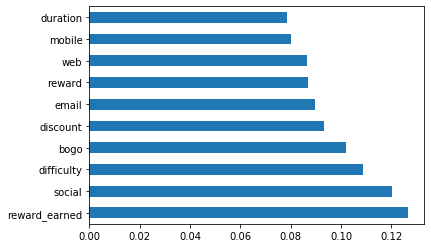

In [843]:
(pd.Series(random_mod.feature_importances_, index=X_train.columns)
   .nlargest(10)
   .plot(kind='barh'))

# 6. Conclusion